In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Metal device set to: Apple M1


2022-01-09 14:46:20.608275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 14:46:20.608360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


last layer output shape:  (None, 7, 7, 768)


In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

# Define our example directories and files
base_dir = './data'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_no_dir = os.path.join(train_dir, 'no') # Directory with our training without mask pictures
train_yes_dir = os.path.join(train_dir, 'yes') # Directory with our training with mask pictures
validation_no_dir = os.path.join(validation_dir, 'no') # Directory with our validation without mask pictures
validation_yes_dir = os.path.join(validation_dir, 'yes')# Directory with our validation with mask pictures

train_no_fnames = os.listdir(train_no_dir)
train_yes_fnames = os.listdir(train_yes_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    #batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          #batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [5]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            #steps_per_epoch = 100,
            epochs = 20,
            #validation_steps = 50,
            verbose = 2)

2022-01-09 14:46:21.853571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-09 14:46:21.853681: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-01-09 14:46:22.554383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-09 14:46:28.584318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 - 8s - loss: 0.2129 - accuracy: 0.9400 - val_loss: 0.0204 - val_accuracy: 0.9891
Epoch 2/20
35/35 - 6s - loss: 0.0552 - accuracy: 0.9818 - val_loss: 0.0060 - val_accuracy: 0.9964
Epoch 3/20
35/35 - 6s - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/20
35/35 - 6s - loss: 0.0263 - accuracy: 0.9927 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 5/20
35/35 - 6s - loss: 0.0408 - accuracy: 0.9873 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 6/20
35/35 - 6s - loss: 0.0314 - accuracy: 0.9927 - val_loss: 0.0522 - val_accuracy: 0.9855
Epoch 7/20
35/35 - 6s - loss: 0.0363 - accuracy: 0.9909 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/20
35/35 - 6s - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.0376 - val_accuracy: 0.9928
Epoch 9/20
35/35 - 6s - loss: 0.0333 - accuracy: 0.9918 - val_loss: 1.5645e-04 - val_accuracy: 1.0000
Epoch 10/20
35/35 - 6s - loss: 0.0448 - accuracy: 0.9891 - val_loss: 0.0121 - val_accuracy: 0.9964
Epoch 11/20
35/35 - 6s - l

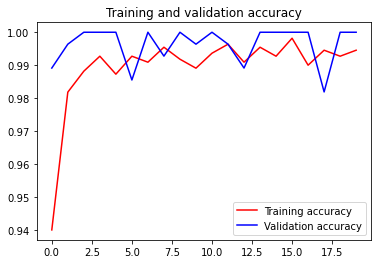

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()